In [50]:
import numpy as np
import os, operator
from scipy.io.wavfile import read as scipy_read
from scipy.signal import butter, lfilter, freqz
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

CSV_PATH = "D://KeyFinderDB/DOC/KeyFinderV2Dataset.csv"
WAV_PATH = "D://KeyFinderDB"

def createProfileMatrix(profile):
    mat = np.empty((12, 12), dtype = np.float)
    for i in range(0, 12):
        mat[i, :] = np.roll(profile, -i)
    return mat

MAJOR_BASE_PROFILE = np.array([6.4, 2.2, 3.5, 2.3, 4.4, 4.1, 2.5, 5.2, 2.4, 3.7, 2.3, 2.9])
MINOR_BASE_PROFILE = np.array([6.4, 2.8, 3.6, 5.4, 2.7, 3.6, 2.6, 4.8, 4.0, 2.7, 3.3, 3.2])
MAJOR_PROFILE_MATRIX = createProfileMatrix(MAJOR_BASE_PROFILE)
MINOR_PROFILE_MATRIX = createProfileMatrix(MINOR_BASE_PROFILE)

KEY_NAMES = ["C", "C#", "D", "Eb", "E", "F", "F#", "G", "G#", "A", "Bb", "B"]

In [51]:
def midiToHertz(d):
    return 440.0 * 2.0 ** ((d - 69.0) / 12.0)

def QFromP(p):
    return p * (np.power(2.0, 1.0 / 12.0) - 1.0)

def w_xk(x, lk, rk):
    return 1.0 - np.cos(2 * np.pi * (x - lk) / (rk + 1 - lk))

def winBounds(Q, fk, N, sampling_rate):
    rang = fk * N / float(sampling_rate)
    lk = (1 - Q / 2.0) * rang
    rk = (1 + Q / 2.0) * rang
    return lk, rk

def findNearestBoundsInSpectrum(fft_freqs, lk, rk):
    li = (np.abs(fft_freqs - lk)).argmin()
    ri = (np.abs(fft_freqs - rk)).argmin()
    if li == ri:
        ri += 1
    return li, ri

def butter_lowpass_filter(data, cutoff, fs, order = 5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype = 'low', analog = False)
    return lfilter(b, a, data)

In [52]:
filepath = os.path.join(WAV_PATH, "10cc_-_Dreadlock_Holiday.wav")
framerate, signal = scipy_read(filepath)
assert(framerate == 44100)
assert(signal.shape[1] == 2)
signal = signal.mean(axis = 1) # Mean of left and right channels
signal = butter_lowpass_filter(signal, 2205.0, 44100.0, order = 5) # Low-pass filtering # TODO : Fisher's filter
signal = signal[::10] # Downsampling -> 4410 Hz

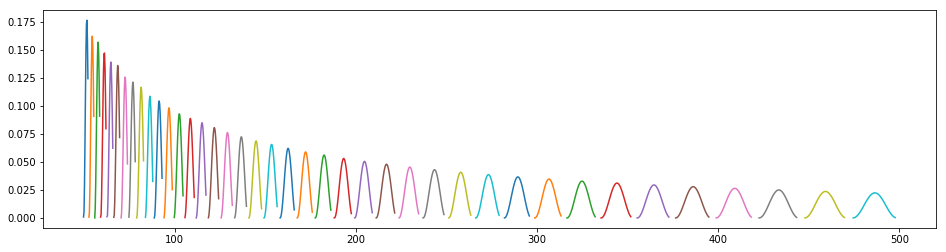

In [53]:
N = 4096 * 4
min_midi_note, max_midi_note = 9, 81
n_octaves = (max_midi_note - min_midi_note) / 12
assert((max_midi_note - min_midi_note) % 12 == 0)
sampling_rate = 4410.0
fft_freqs = np.fft.fftfreq(N) * sampling_rate
T = len(signal) - N
Q = QFromP(0.8)

wins = list()
for fk in midiToHertz(np.arange(min_midi_note, max_midi_note)):
    lk, rk = winBounds(Q, fk, N, sampling_rate)
    li, ri = findNearestBoundsInSpectrum(fft_freqs, lk, rk)
    win = w_xk(fft_freqs[li:ri+1], lk, rk)
    # win = w_xk(np.arange(li, ri + 1), lk, rk)
    win /= win.sum()
    wins.append((li, ri, win))
    
plt.figure(figsize = (16, 4))
for i in range(40):
    li, ri, w = wins[i]
    plt.plot(fft_freqs[li:ri+1], w)
plt.show()

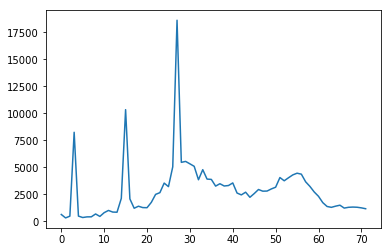

In [54]:
hist = {
    "C" : 0, "C#" : 0, "D" : 0, "Eb" : 0, "E" : 0, "F" : 0, "F#" : 0, "G" : 0,
    "G#" : 0, "A" : 0, "Bb" : 0, "B" : 0, "Cm" : 0, "C#m" : 0, "Dm" : 0, "Ebm" : 0,
    "Em" : 0, "Fm" : 0, "F#m" : 0, "Gm" : 0, "G#m" : 0, "Am" : 0, "Bbm" : 0, "Bm" : 0
}

bla_win = np.blackman(N)

def computeCoefs(i):
    f = np.fft.fft(bla_win * signal[i:i+N])
    f = np.sqrt(f.real ** 2 + f.imag ** 2)
    coefs = list()
    for tmp in wins:
        li, ri, win = tmp
        coefs.append((win * f[li:ri+1]).sum())
    coefs = np.array(coefs)
    reduced_coefs = np.reshape(coefs, (n_octaves, 12))
    reduced_coefs = 0.8 * reduced_coefs.max(axis = 0) + 0.2 * reduced_coefs.mean(axis = 0)
    return coefs, reduced_coefs

coefs, reduced_coefs = computeCoefs(105)
plt.plot(coefs)
plt.show()

In [55]:
def scoreCoefs(hist, coefs):
    major_scores, minor_scores = list(), list()
    for j in range(12):
        major_scores.append(pearsonr(coefs, MAJOR_PROFILE_MATRIX[j])[0])
        minor_scores.append(pearsonr(coefs, MINOR_PROFILE_MATRIX[j])[0])
    major_scores = np.array(major_scores)
    minor_scores = np.array(minor_scores)
    best_major_key = major_scores.argmax()
    best_minor_key = minor_scores.argmax()
    if major_scores[best_major_key] > minor_scores[best_minor_key]:
        hist[KEY_NAMES[(min_midi_note + best_major_key) % 12]] += 1
    else:
        hist[KEY_NAMES[(min_midi_note + best_minor_key) % 12] + "m"] += 1
        
scoreCoefs(hist, reduced_coefs)

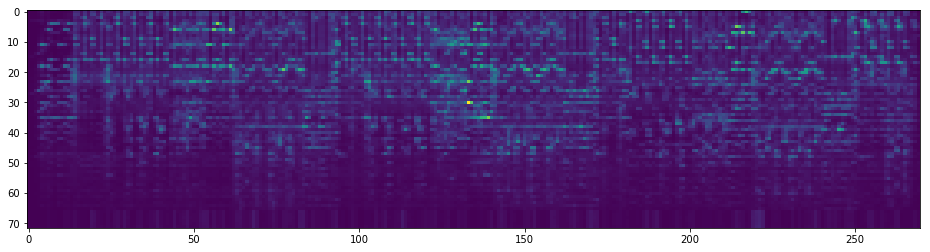

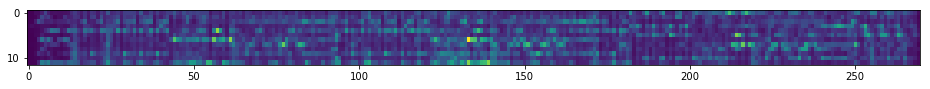

In [56]:
chromagram, reduced_chromagram = list(), list()
i = 0
while i < T:
    coefs, reduced_coefs = computeCoefs(i)
    chromagram.append(coefs)
    reduced_chromagram.append(reduced_coefs)
    scoreCoefs(hist, reduced_coefs)
    i += (N / 4)
    
plt.figure(figsize = (16, 4))
chromagram = np.array(chromagram).T
plt.imshow(chromagram, aspect = "auto")
plt.show()

plt.figure(figsize = (16, 1))
reduced_chromagram = np.array(reduced_chromagram).T
plt.imshow(reduced_chromagram, aspect = "auto")
plt.show()

In [57]:
predicted_key_name = max(hist.iteritems(), key=operator.itemgetter(1))[0]
print(predicted_key_name)

Bbm
